In [1]:
import numpy as np
from scipy.stats import norm, gamma
from functools import partial
from scipy.integrate import cumtrapz, quad
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

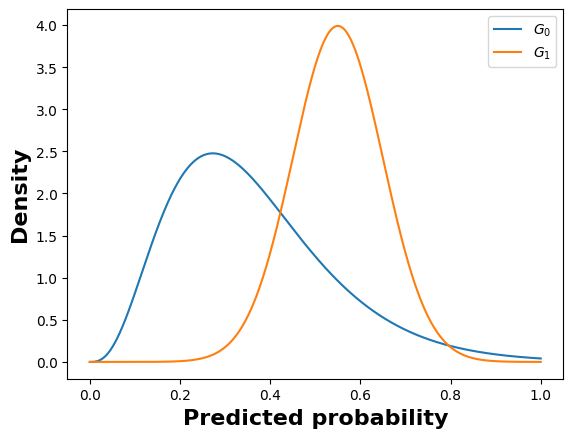

In [2]:
def x_transform_1(x):
    x = np.array(x)
    return 11 * x

def x_transform_3(x):
    x = np.array(x)
    return 10*(x-0.55)

def transfrom_distribution(old_dist, x_transform, x):
    x_t = x_transform(x)
    y = old_dist(x_t)
    # Set the PDF to zero outside the [0, 1] interval
    ind = (x >= 0) & (x <= 1)
    y = y * ind
    return y

def transfrom_distribution_norm(old_dist, x_transform, norm_area, x):
    x_t = x_transform(x)
    y = old_dist(x_t) / norm_area
    # Set the PDF to zero outside the [0, 1] interval
    ind = (x >= 0) & (x <= 1)
    y = y * ind
    return y

def custom_distribution(old_dist, x_transform):
    """
    Create a new distribution by transforming the variable of an existing distribution.
    :param old_dist: existing distribution
    :param x_transform: transformation function
    :return: new distribution
    """
    new_dist = partial(transfrom_distribution, old_dist, x_transform)
    area = quad(new_dist, 0, 1)[0]

    # Normalize the distribution so the area under the curve is 1
    return partial(transfrom_distribution_norm, old_dist, x_transform, area)

def plot_densities(func1, func2, nb_points=1000):
    fig, ax = plt.subplots()
    x = np.linspace(0, 1, nb_points)
    y1 = func1(x)
    y2 = func2(x)
    ax.plot(x, y1, label="$G_0$")
    ax.plot(x, y2, label="$G_1$")
    ax.legend()
    ax.set_xlabel("Predicted probability", fontsize=16, fontweight='bold')
    ax.set_ylabel("Density", fontsize=16, fontweight='bold')
    plt.show()

func8 = custom_distribution(gamma(a=4, scale=1).pdf, x_transform_1)
func9 = custom_distribution(norm.pdf, x_transform_3)

plot_densities(func8, func9)

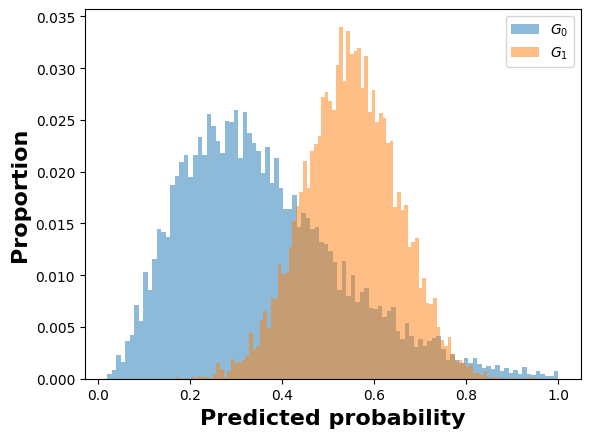

In [3]:
def generate_samples(inverse_func, num_samples, seed=None):
    """
    Generate samples from a distribution.
    :param inverse_func: inverse CDF function that generates the distribution
    :param num_samples: number of samples to generate
    :param seed:
    :return:
    """
    np.random.seed(seed)
    # Generate uniform samples
    u = np.random.uniform(0, 1, num_samples)
    np.random.seed(None)
    # Generate samples from the distribution
    return inverse_func(u)


def pdf_to_cdf(pdf_func, num_points=1000):
    """
    Convert a PDF function to a CDF function.
    :param pdf_func:
    :param num_points:
    :return:
    """
    x = np.linspace(0, 1, num_points)
    pdf_values = pdf_func(x)
    cdf_values = cumtrapz(pdf_values, x, initial=0)
    # Create interpolation function
    cdf_func = interp1d(x, cdf_values, kind='linear', bounds_error=False, fill_value=(0, 1))
    return np.vectorize(cdf_func)


def cdf_to_inverse(cdf_func, num_points=1000):
    """
    Convert a CDF function to an inverse CDF function.
    :param cdf_func:
    :param num_points:
    :return:
    """
    x = np.linspace(0, 1, num_points)
    cdf_values = cdf_func(x)
    # Create interpolation function
    inverse_func = interp1d(cdf_values, x, kind='linear', bounds_error=False, fill_value=(0, 1))
    return np.vectorize(inverse_func)

inv_cdf_f8 = cdf_to_inverse(pdf_to_cdf(func8))
inv_cdf_f9 = cdf_to_inverse(pdf_to_cdf(func9))

Q0 = generate_samples(inv_cdf_f8, 10000, seed=0)
Q1 = generate_samples(inv_cdf_f9, 10000, seed=0)

plt.hist(Q0, bins=100, density=False, weights=np.ones(len(Q0)) / len(Q0), alpha=0.5, label="$G_0$")
plt.hist(Q1, bins=100, density=False, weights=np.ones(len(Q1)) / len(Q1), alpha=0.5, label="$G_1$")
plt.xlabel("Predicted probability", fontsize=16, fontweight='bold')
plt.ylabel("Proportion", fontsize=16, fontweight='bold')
plt.legend()